# Prüfungsleistung Data Science

- Matthias Hagg 
- 4392350 
- T-INF19E

---

# Themengebiet

ARMA Modell zum Klimawandel

---

## Imports

In [3]:
#Imports aller benötigten Biblioteken
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import numpy as np
import pandas as pd
import statistics
import copy
from datetime import datetime
from matplotlib.pyplot import figure
from pandas.plotting import lag_plot
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

#Einlesen und speichern der Datensets. 
#Die Variable "daten_groß" beinhaltet das Datenset zu den täglichen Wetterdaten von 1985 bis 2021. (13473 Datensätze)
#Die Variable "daten_klein" beinhaltet das Datenset zu den täglichen Wetterdaten von 2019 bis 2020. (731 Datensätze)
daten_groß = pd.read_csv("Daten/climatechange_basel.csv", sep = ';')           # 1985 bis 2021
daten_klein = pd.read_csv("Daten/climatechange_basel_2_Jahre.csv", sep = ';')  # 2019 bis 2020

sns.set()

---

## Task 1

### Performa an EDA and plot the data. What can you see now?

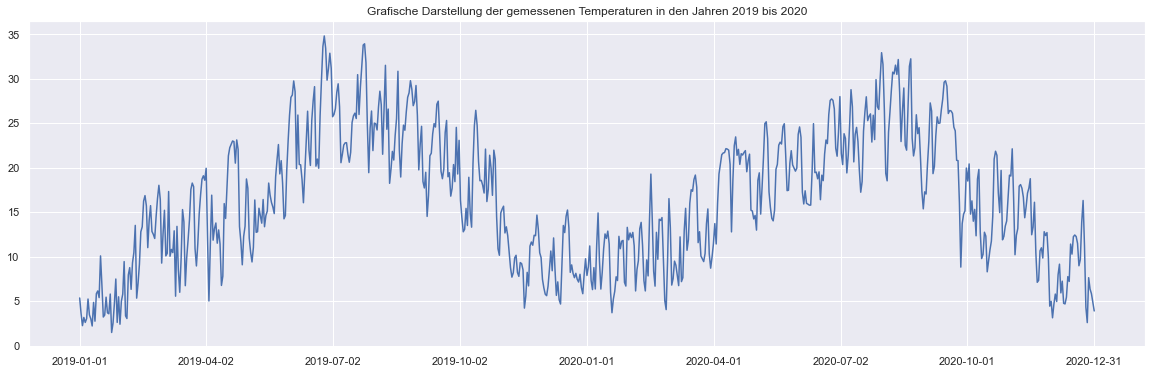

In [2]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_1=copy.deepcopy(daten_klein)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_1["timestamp"]=daten_lokal_1["timestamp"].str[0:10]

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Gemessene Temperaturen (täglich) von 2019 bis 2020
plt.figure(figsize=(20, 6))
plt.plot(daten_lokal_1["timestamp"], daten_lokal_1["Basel Temperature [2 m elevation corrected]"])
plt.xticks(np.arange(0, 731, step=91.25))
plt.title("Grafische Darstellung der gemessenen Temperaturen in den Jahren 2019 bis 2020")
plt.show()

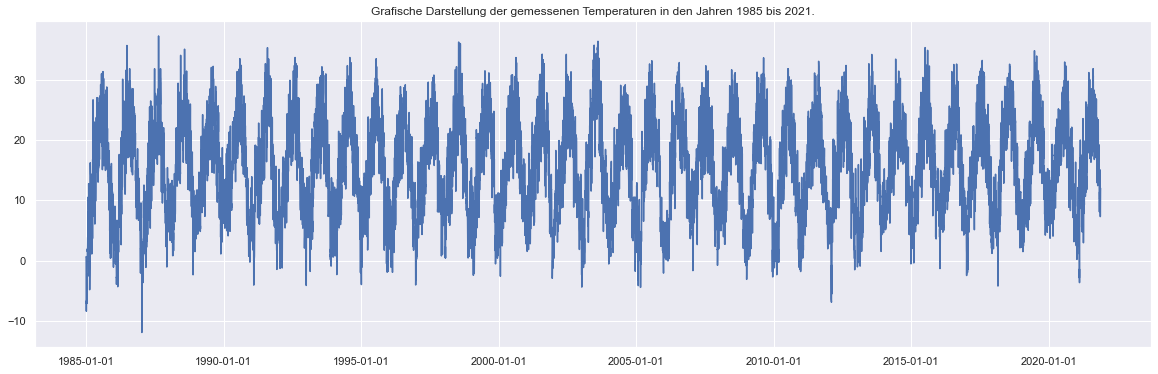

In [3]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_2=copy.deepcopy(daten_groß)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_2["timestamp"]=daten_lokal_2["timestamp"].str[0:10]

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Gemessene Temperaturen (täglich) von 1985 bis 2021
plt.figure(figsize=(20, 6))
plt.plot(daten_lokal_2["timestamp"], daten_lokal_2["Basel Temperature [2 m elevation corrected]"])
plt.xticks(np.arange(0, 13473, step=1826.15))
plt.title("Grafische Darstellung der gemessenen Temperaturen in den Jahren 1985 bis 2021.")
plt.show()

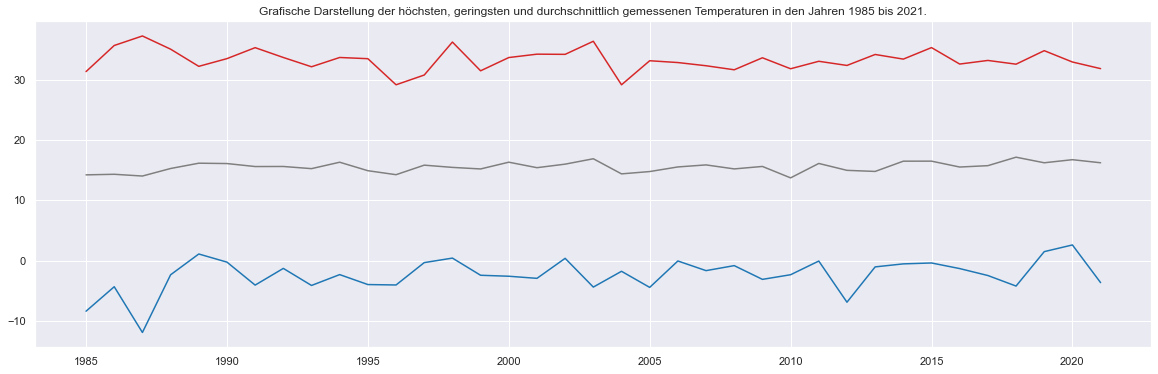

In [4]:
#Deepcopy der Daten, um die Grunddaten nicht zu beeinflussen.
daten_lokal_3=copy.deepcopy(daten_groß)

#Timestamp besteht in Grunddaten aus Datum und Uhrzeit. Da Nur das Datum benötigt wird, wird der Timestamp entsprechend zugeschnitten.
daten_lokal_3["timestamp"]=daten_lokal_3["timestamp"].str[0:4]

#Startjahr für die Schleife. Soll das kleine Datenset verwendet werden, muss das Startjahr auf 2019 gesetzt werden.
startjahr=1985

#Anlegen der für die Berechnung benötigten Listen
jahre=[]
temp_min=[]
temp_max=[]
temp_schnitt=[]

#Temperaturdaten anhand der Jahre gruppieren
jahresgruppen = daten_lokal_3.groupby(["timestamp"])

#Schleife um alle Jahresgruppen zu durchlaufen. Soll das kleine Datenset verwendet werden, muss die Abbruchbedingung auf 2020 gesetzt werden.
while startjahr <= 2021:
    
    #Erhalte alle Daten aus dem aktuellen Jahr
    gruppendatensatz=jahresgruppen.get_group(str(startjahr))
    
    #Daten in zuvor angelegte Listen speichern. Gespeichert werden Jahr, höchst-, geringste- und niedrigste Temperatur
    jahre.append(startjahr)
    temp_min.append(min((gruppendatensatz["Basel Temperature [2 m elevation corrected]"])))
    temp_max.append(max((gruppendatensatz["Basel Temperature [2 m elevation corrected]"])))
    temp_schnitt.append(statistics.mean(gruppendatensatz["Basel Temperature [2 m elevation corrected]"]))
    
    #Erhöhung des nächsten Jahres für den nächsten Schleifendurchlauf
    startjahr=startjahr+1

#Erstellen der Grafik:
#Festlegen der Größe, Titel und Schrittweite
#Darstellung: Höchsten (rot), geringsten (blau) und durchschnittlich (grau) gemessenen Temperaturen in den Jahren 1985 bis 2021.
plt.figure(figsize=(20, 6))
plt.title("Grafische Darstellung der höchsten, geringsten und durchschnittlich gemessenen Temperaturen in den Jahren 1985 bis 2021.")
plt.plot(jahre, temp_min, color = 'tab:blue')
plt.plot(jahre, temp_max, color = 'tab:red')
plt.plot(jahre, temp_schnitt, color = 'tab:grey')
plt.show()

Aus den drei oben dargestellten Temperaturdaten as Basel lassen sich folgende Aussagen treffen:
- Basel hatte in den Jahren 2019 und 2020 im Tagesschnitt keine Temperaturen unter 0°C.
- Die kältesten Temperaturen in den Jahren 1985 bis 2021 steigen tendenziell leicht an.
- Die Temperatur im Jahresmittel steigt tendenziell im Zeitraum von 1985 bis 2021 an.

---

## Task 2

### Is Temperature a Random Walk (with Drift)?

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.
Plot the data and test whether it follows a random walk (with drift).

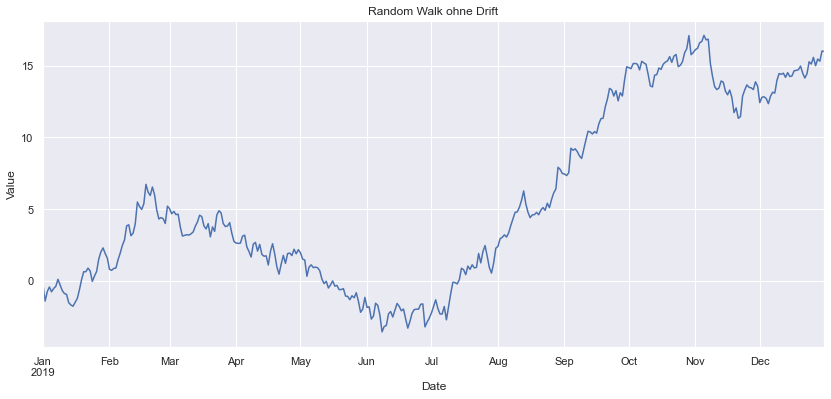

In [5]:
#Beispiel eines Random Walk
#Bei Random Walk stehen die Folgewerte immer in Verbindung mit den zuvor festgelegten Werten.

mean = 0
sigma = 0.5
n_pts = 365

#Erzeuge Daten und Zufallszahlen
dates = pd.date_range(start='1/1/2019', periods=n_pts)
epsilon = np.random.normal(mean,sigma,n_pts)

#Erzeuge Daten, welche bei auf den voerhergegangenen Wert addiert werden
y0 = 0
vals = y0 + np.cumsum(epsilon) 
time_series =  pd.Series(vals, index=dates)

#Erstellen der Grafik Random Walk ohne Drift
plt.title("Random Walk ohne Drift")
ax = time_series.plot(figsize=(14,6))
ax.set_ylabel("Value")
ax.set_xlabel("Date")
plt.show()

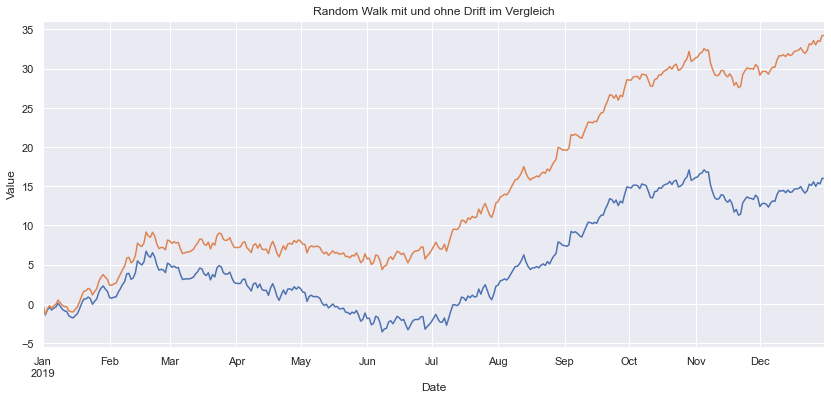

In [6]:
#Beispiel eines Random Walk mit Drift (auf Basis von Werten aus vorherigem Code-Beispiel)
#Bei Random Walk stehen die Folgewerte immer in Verbindung mit den zuvor festgelegten Werten, werden jedoch durch eine definierte
# Konstante beinflusst
drift = 0.05
drift_werte = y0 + np.cumsum(epsilon + drift) 
time_drift =  pd.Series(drift_werte, index=dates)

#Erstellen der Grafik
#Blaue Linie stellt den Random Walk ohne Drift dar
#Orangene Linie stellt den Random Walk mit Drift dar
plt.title("Random Walk mit und ohne Drift im Vergleich")
ax = time_series.plot(figsize=(14,6))
time_drift.plot()
ax.set_ylabel("Value")
ax.set_xlabel("Date")
plt.show()

Entsprechend der Definition und der beiden Beispiele von Random Walk und Random Walk mit Drift lassen sich folgende Aussagen treffen:
- Temperaturverläufe sind ein Random Walk
    - Temperaturverläufe entstehen nicht zufällig. Die Temperatur an Tag y1 ist nicht vollständig unabhängig von der Temperatur a Tag y0, dennoch können die Werte zufällig steigen bzw. sinken.
- Temperaturverläufe haben einen Drift
    - Temperaturverläufe besitzen zwei Arten von Drift. 
        - Auf kürzere Laufzeit sind sie der Jahreszeit und damit saisonalen Verläufen unterworfen. Somit entsteht hier ein Sommer/Winter-Drift.
        - Auf Längere Sicht gibt es einen Anstieg der durchschnittlichen Jahrestemperatur (siehe Task 1), welcher ebenfalle einen leichten Drift in höhere Werte darstellt.

---

## Task 3

### Look at Autocorrelations

If the temperature series is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


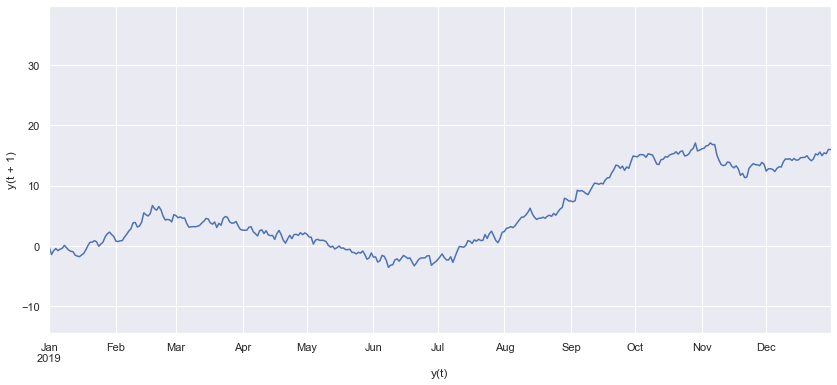

In [12]:
# Um Autokorrelationen betrachten zu können, müssen die Temperaturdaten vorher stationär gemacht werden
daten_lokal_4 = copy.deepcopy(daten_groß)
temperaturen = daten_lokal_4["Basel Temperature [2 m elevation corrected]"]
ax = time_series.plot(figsize=(14,6))
lag_plot(temperaturen)
plt.show()

In [8]:
daten_lokal_5 = copy.deepcopy(daten_groß)
series = daten_lokal_5["Basel Temperature [2 m elevation corrected]"]
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.921946
t+1  0.921946  1.000000


- Bei diesen Temperaturdaten liegt eine stark positive Korrelation vor.
    - Die Korrelation liegt mit rund 0.9 sehr nahe der 1. Dies sagt aus, dass die einzelnen Temperaturdaten eine hohe gegenseitige Beziehung zueinander haben. Eine postitive Korrelation bedeutet, das die Werte über eine längeren Bereich ansteigen.

## Task 4

### Which ARMA Model is Best?

Recall from theory that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

Test MSE: 3.228


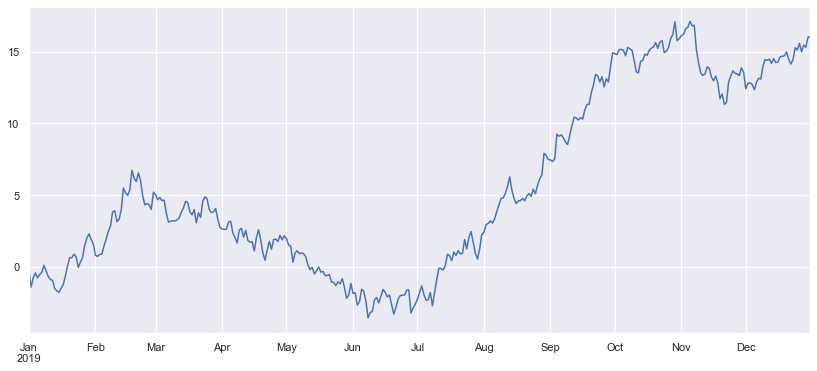

In [23]:
daten_lokal_6 = copy.deepcopy(daten_groß)
# create lagged dataset
series = daten_lokal_6["Basel Temperature [2 m elevation corrected]"]
values = DataFrame(series.values)
dataframe = concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-7], X[len(X)-7:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
ax = time_series.plot(figsize=(14,6))
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

In [40]:
# load dataset
daten_lokal_7 = copy.deepcopy(daten_klein)
series = daten_lokal_7["Basel Temperature [2 m elevation corrected]"]
anzahl_Daten=len(series)
# split dataset
X = series.values
train, test = X[1:len(X)-700], X[len(X)-700:]
# train autoregression
model = AutoReg(train, lags=900)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
#for i in range(len(predictions)):
    #print('predicted=%f, expected=%f' % (predictions[i], test[i]))
#rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

ValueError: The model specification cannot be estimated. The model contains 30 regressors (1 trend, 0 seasonal, 29 lags) but after adjustment for hold_back and creation of the lags, there are only 1 data points available to estimate parameters.

In [29]:
daten_lokal_7 = copy.deepcopy(daten_klein)
series = daten_lokal_7["Basel Temperature [2 m elevation corrected]"]
len(series)

predicted=10.479707, expected=4.325029
predicted=5.892575, expected=2.595029
predicted=4.993171, expected=7.645029
predicted=9.477604, expected=6.365028
predicted=6.768113, expected=5.845029
predicted=7.468488, expected=4.835029
predicted=6.075818, expected=3.905029
Test RMSE: 3.338


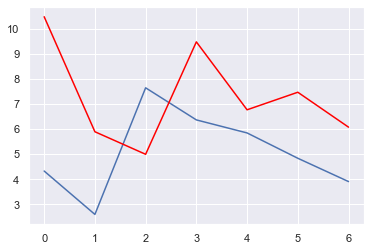

In [7]:
# create and evaluate an updated autoregressive model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
daten_lokal_7 = copy.deepcopy(daten_klein)
series = daten_lokal_7["Basel Temperature [2 m elevation corrected]"]
# split dataset
X = series.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
window = 29
model = AutoReg(train, lags=29)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

---

## Task 5

### Don't Throw Out That Winter Coat Yet?

Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.